In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import random
from typing import Tuple, List, Dict, Optional

np.random.seed(42)

In [4]:
train_challenges_path = '/kaggle/input/arc-prize-2025/arc-agi_training_challenges.json'
train_solutions_path = '/kaggle/input/arc-prize-2025/arc-agi_training_solutions.json'
test_challenges_path = '/kaggle/input/arc-prize-2025/arc-agi_test_challenges.json'
sample_submission_path = '/kaggle/input/arc-prize-2025/sample_submission.json'
evaluation_challenges_path = '/kaggle/input/arc-prize-2025/arc-agi_evaluation_challenges.json'
evaluation_solutions_path = '/kaggle/input/arc-prize-2025/arc-agi_evaluation_solutions.json'

# Load JSON files
with open(train_challenges_path, 'r') as f:
    train_challenges = json.load(f)

with open(train_solutions_path, 'r') as f:
    train_solutions = json.load(f)

with open(test_challenges_path, 'r') as f:
    test_challenges = json.load(f)

with open(sample_submission_path, 'r') as f:
    sample_submission = json.load(f)

with open(evaluation_challenges_path, 'r') as f:
    eval_challenges = json.load(f)

with open(evaluation_solutions_path, 'r') as f:
    eval_solutions = json.load(f)

print(f"Loaded {len(train_challenges)} training challenges")
print(f"Loaded {len(train_solutions)} training solutions")
print(f"Loaded {len(eval_challenges)} eval challenges")
print(f"Loaded {len(eval_solutions)} eval solutions")
print(f"Loaded {len(test_challenges)} test challenges")

Loaded 1000 training challenges
Loaded 1000 training solutions
Loaded 120 eval challenges
Loaded 120 eval solutions
Loaded 240 test challenges


### ARC Data Loader Class

This `ARCDataLoader` class processes ARC dataset challenges and solutions by:

- Padding each input and output grid to a fixed size (30x30).
- Converting them into PyTorch tensors stored on CPU.
- Organizing the data per task into a list of dictionaries with keys `inputs`, `outputs`, and `task_id`.
- The last input and output entries correspond to the test input and solution respectively


Loading data returns a list of task dictionaries. Each dictionary represents one task and has the following structure:

```python
{
    'inputs': List[Tensor],   # If padded each tensor is a 30x30 grid (torch.Tensor of shape [30, 30])
    'outputs': List[Tensor],  # Each tensor corresponds to an input, also [30, 30]
    'task_id': str            # Unique identifier for the task
}

In [56]:
from matplotlib.colors import ListedColormap

class ARCDatasetLoader:
    def __init__(self, pad_value = None):

        # if pad_value != None, images will be padded when calling ARCDatasetLoader.load()
        self.pad_value = pad_value

        # Colors for plotting
        self.colors = [
        '#1c1c1c',  # black
        '#176cff',  # blue
        '#db1414',  # red
        '#07b819',  # green
        '#ffee03',  # yellow
        '#969696',  # grey
        '#ff00dd',  # pink
        '#ff9100',  # orange
        '#00ffd9',  # teal
        '#a65628',  # brown
        '#ffffff',  # white (padding)
        ]
        self.cmap = ListedColormap(self.colors)

    def pad(self, image, target_rows=30, target_cols=30):
        """
        Pads a 2D list (image) to the target size with pad_value.

        Returns:
            list of lists: padded 2D list of shape (target_rows x target_cols)
        """

        if (self.pad_value == None):
            return image
            
        current_rows = len(image)
        current_cols = max(len(row) for row in image) if current_rows > 0 else 0

        padded_rows = []
        for row in image:
            padded_row = row + [self.pad_value] * (target_cols - len(row))
            padded_rows.append(padded_row[:target_cols])

        for _ in range(target_rows - current_rows):
            padded_rows.append([self.pad_value] * target_cols)

        return padded_rows[:target_rows]

    def load(self, challenges, solutions):
        """
        Constructs a list of task dictionaries from given challenges and solutions.

        Args:
            challenges (dict): Dictionary with task data including 'train' and 'test'.
            solutions (dict): Dictionary with task_id mapped to corresponding test outputs.

        Returns:
            List[Dict]: Dataset with keys 'inputs', 'outputs', and 'task_id'
        """
            
        dataset = []

        for task_id, task in challenges.items():
            task_dict = {}

            # Pad and collect train inputs/outputs
            _inputs = [self.pad(item["input"]) for item in task["train"]]
            _outputs = [self.pad(item["output"]) for item in task["train"]]

            # Pad and add test input/solution
            _inputs.append(self.pad(task["test"][0]["input"]))
            _outputs.append(self.pad(solutions[task_id][0]))

            # Convert to tensors
            task_dict['inputs'] = [torch.tensor(inp).long() for inp in _inputs]
            task_dict['outputs'] = [torch.tensor(out).long() for out in _outputs]
            task_dict['task_id'] = task_id

            dataset.append(task_dict)

        return dataset

    def plot_task(self, task_dict):
        """
        Plot all input-output pairs for a single task with grid lines.
        Layout: inputs on top row, outputs on bottom row.
    
        Args:
            task_dict (dict): A dictionary with keys 'inputs', 'outputs', 'task_id'.
                              'inputs' and 'outputs' are lists of 2d torch tensors.
        """
        inputs = task_dict['inputs']
        outputs = task_dict['outputs']
        task_id = task_dict.get('task_id', 'Unknown Task')
        num_pairs = len(inputs)


        # Find the maximum dimension across all tensors
        max_dim = 0
        for tensor in inputs + outputs:
            for dim in tensor.shape:
                if dim > max_dim:
                    max_dim = dim
                    
        fig_size = max(3, int(max_dim * 0.2))
        
            
        fig, axes = plt.subplots(2, num_pairs, figsize=(fig_size * num_pairs, 2*fig_size))
        if num_pairs == 1:
            axes = axes[:, np.newaxis]  # ensure 2D shape if 1 pair
    
        fig.suptitle(f"Task ID: {task_id}", fontsize=11)
    
        for i in range(num_pairs):
            inp = inputs[i].cpu().numpy() if isinstance(inputs[i], torch.Tensor) else inputs[i]
            out = outputs[i].cpu().numpy() if isinstance(outputs[i], torch.Tensor) else outputs[i]
    
            for row, data, label in zip([0, 1], [inp, out], ['Input', 'Output']):
                    
                ax = axes[row][i]
                h, w = data.shape
    
                # Create grid edges for pcolormesh (note +1 for edges)
                x = np.arange(w + 1)
                y = np.arange(h + 1)
    
                # Plot with pcolormesh
                mesh = ax.pcolormesh(x, y, data, cmap=self.cmap, edgecolors='#333333', linewidth=0.1, shading='flat', vmin=0, vmax=len(self.colors))
    
                if i == num_pairs-1: 
                    label = 'Task' if label == 'Input' else 'Solution'
                    grid_title = label + f" ({w}x{h})"
                else: 
                    grid_title = f"Ex.{i+1} {label} ({w}x{h})"
                    
                ax.set_title(grid_title, fontsize=10, loc='left')
    
                # # Set aspect ratio so pixels are square
                ax.set_aspect('equal')
    
                # # Invert y-axis to match image display convention
                ax.invert_yaxis()
    
                # Remove ticks and labels
                ax.set_xticks([])
                ax.set_yticks([])
    
                # Remove subplot borders
                for spine in ax.spines.values():
                    spine.set_visible(False)
    
        plt.show()

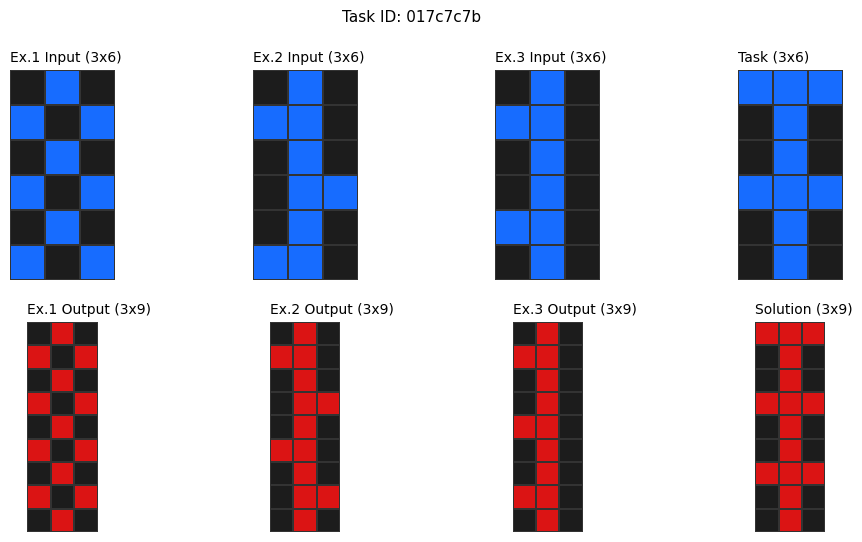

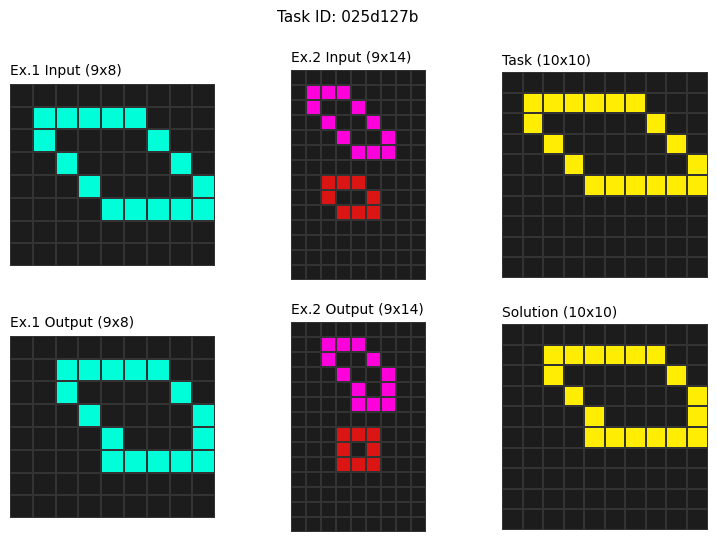

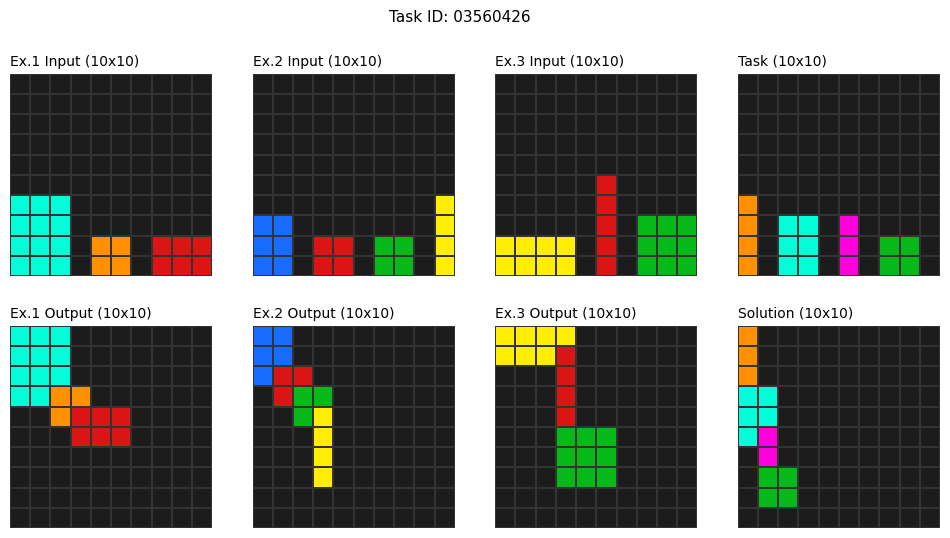

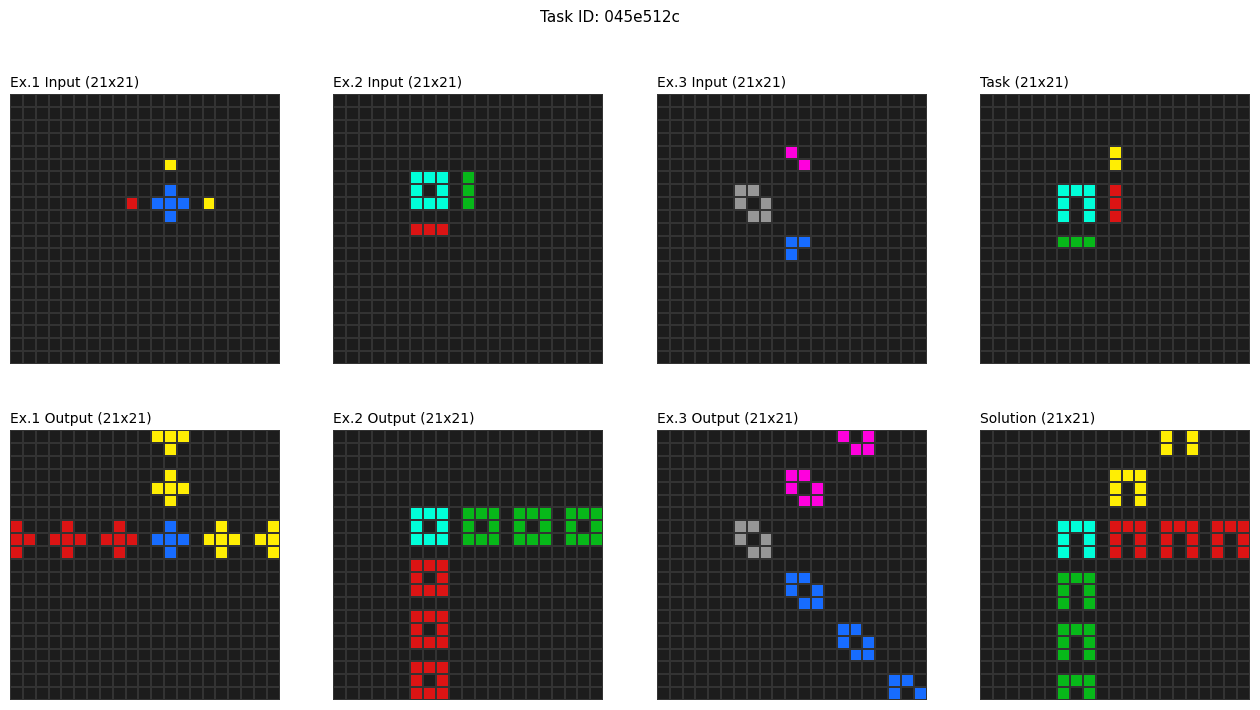

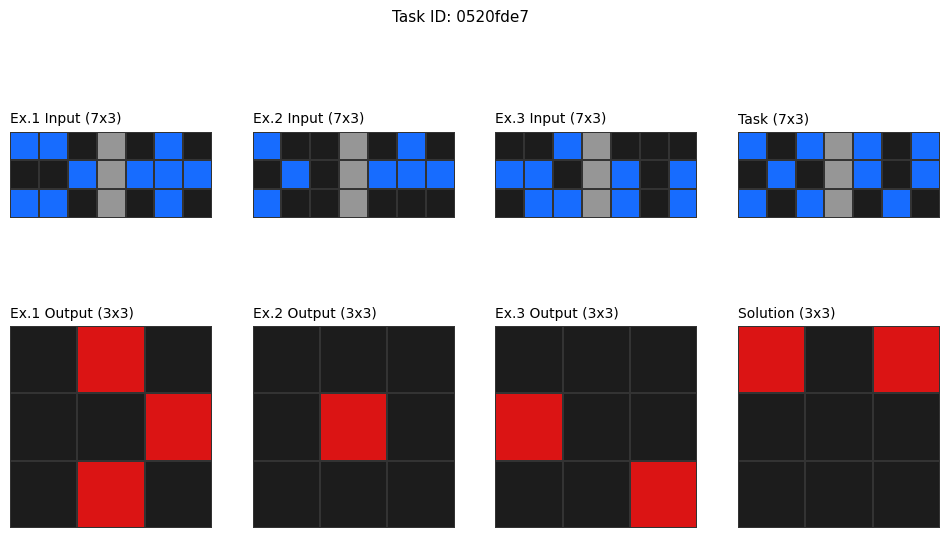

In [58]:
dataloader = ARCDatasetLoader(pad_value=None)

train_set = dataloader.load(train_challenges, train_solutions)
eval_set = dataloader.load(eval_challenges, eval_solutions)

# Plot some example tasks
for i in range(5,10):
    dataloader.plot_task(train_set[i])

In [59]:
def tensor_to_str(tensor):
    # Convert 2D tensor to a nicely formatted string
    rows = []
    for row in tensor.tolist():
        rows.append(" ".join(f"{int(v)}" for v in row))
    return "\'\'\' ""\n" + "\n".join(rows) + "\n\'\'\'"

def generate_prompt(data):
    inputs = data["inputs"]
    outputs = data["outputs"]
    task_id = data["task_id"]

    prompt_lines = []
    prompt_lines.append("Task Description:")
    prompt_lines.append("You are presented with a set of grid-based input-output "
                        "examples that follow an underlying transformation rule. "
                        "Each grid (represented as a 2D matrix of values) undergoes "
                        "a specific modification that may involve spatial, structural, "
                        "or logical reasoning. Your goal is to learn the transformation "
                        "rule from the examples and apply the same reasoning to a final "
                        "task input. This task input is a new grid where the correct "
                        "output is not shown — your job is to infer and predict it."
                        "Use a structured iterative approach to solving the task:\n"
                        "1. Analyze the examples to find structures or simple relationships.\n"
                        "2. Build a hypothesis for the underlying rule.\n"
                        "3. Apply the hypothesis to all examples to reconstruct the outputs\n"
                        "4. Check if the reconstructed outputs match the given outputs:\n"
                        "\t If they do -> Apply hypothesis to the task input to generate the solution grid.\n"
                        "\t If they don\'t -> Return to step 1 and repeat.\n")

    # Show all except the last input-output pair
    for i in range(len(inputs) - 1):
        d_in = inputs[i].shape
        d_out = outputs[i].shape
        
        prompt_lines.append(f"### Example {i+1}:")
        prompt_lines.append(f"- Input: ({d_in[0]}x{d_in[1]})")
        prompt_lines.append(tensor_to_str(inputs[i]))
        prompt_lines.append(f"- Output: ({d_out[0]}x{d_out[1]})")
        prompt_lines.append(tensor_to_str(outputs[i]))
        prompt_lines.append("")

    # Show the last input as task
    d_in = inputs[-1].shape
    prompt_lines.append(f"### Task:")
    prompt_lines.append(f"- Input: ({d_in[0]}x{d_in[1]})")
    prompt_lines.append(tensor_to_str(inputs[-1]))
    prompt_lines.append("- Output: ?")

    return "\n".join(prompt_lines)

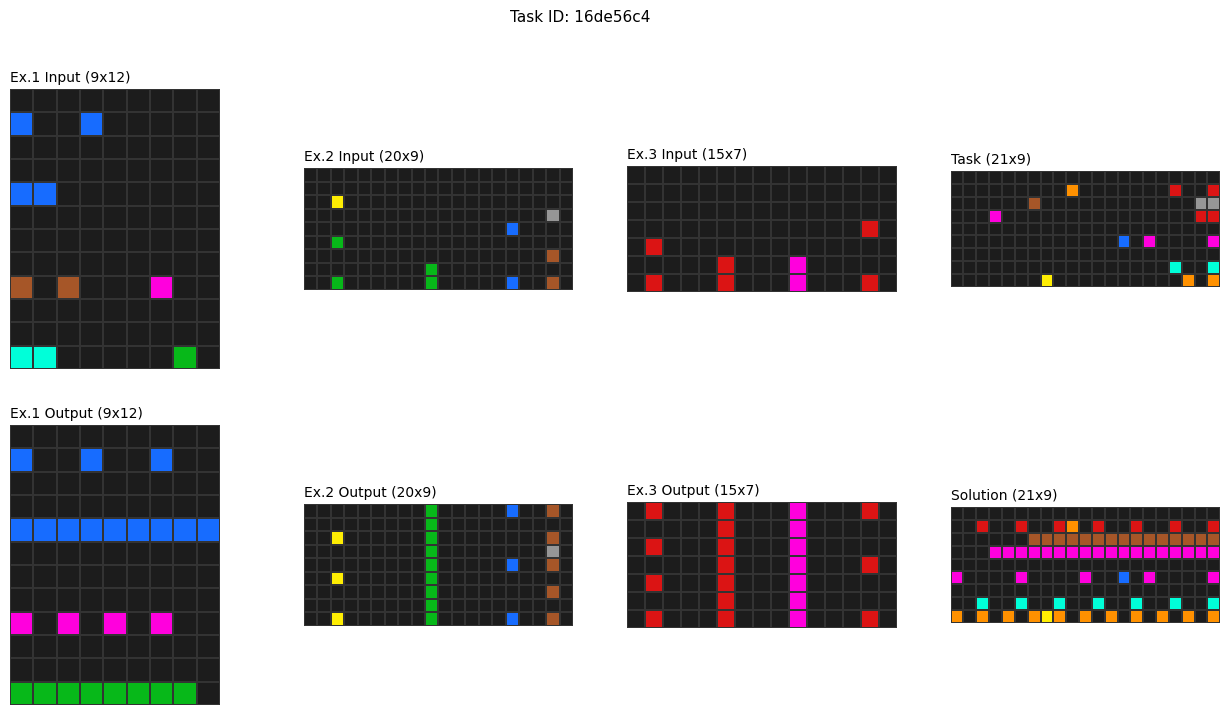

Task Description:
You are presented with a set of grid-based input-output examples that follow an underlying transformation rule. Each grid (represented as a 2D matrix of values) undergoes a specific modification that may involve spatial, structural, or logical reasoning. Your goal is to learn the transformation rule from the examples and apply the same reasoning to a final task input. This task input is a new grid where the correct output is not shown — your job is to infer and predict it.Use a structured iterative approach to solving the task:
1. Analyze the examples to find structures or simple relationships.
2. Build a hypothesis for the underlying rule.
3. Apply the hypothesis to all examples to reconstruct the outputs
4. Check if the reconstructed outputs match the given outputs:
	 If they do -> Apply hypothesis to the task input to generate the solution grid.
	 If they don't -> Return to step 1 and repeat.

### Example 1:
- Input: (12x9)
''' 
0 0 0 0 0 0 0 0 0
1 0 0 1 0 0 0 0 0


In [61]:
task_num = 6
example_task = eval_set[task_num]


dataloader.plot_task(example_task)

prompt = generate_prompt(example_task)
print(prompt)
print("")
print("Solution:")
print(example_task["outputs"][-1].numpy())